# Using AWS SageMaker Linear Learner for Boston Housing Regression

# Imports & Reading in Data

In [19]:
#Data Source: https://www.kaggle.com/c/boston-dataset/data
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.read_csv('boston_data.csv')
df.head()

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,black,lstat,medv
0,0.15876,0.0,10.81,0.0,0.413,5.961,17.5,5.2873,4.0,305.0,19.2,376.94,9.88,21.7
1,0.10328,25.0,5.13,0.0,0.453,5.927,47.2,6.9320,8.0,284.0,19.7,396.90,9.22,19.6
2,0.34940,0.0,9.90,0.0,0.544,5.972,76.7,3.1025,4.0,304.0,18.4,396.24,9.97,20.3
3,2.73397,0.0,19.58,0.0,0.871,5.597,94.9,1.5257,5.0,403.0,14.7,351.85,21.45,15.4
4,0.04337,21.0,5.64,0.0,0.439,6.115,63.0,6.8147,4.0,243.0,16.8,393.97,9.43,20.5


In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404 entries, 0 to 403
Data columns (total 14 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   crim     404 non-null    float64
 1   zn       404 non-null    float64
 2   indus    404 non-null    float64
 3   chas     404 non-null    float64
 4   nox      404 non-null    float64
 5   rm       404 non-null    float64
 6   age      404 non-null    float64
 7   dis      404 non-null    float64
 8   rad      404 non-null    float64
 9   tax      404 non-null    float64
 10  ptratio  404 non-null    float64
 11  black    404 non-null    float64
 12  lstat    404 non-null    float64
 13  medv     404 non-null    float64
dtypes: float64(14)
memory usage: 44.3 KB


Our response variable is **medv**: median value of owner occupied homes in thousands.

In [21]:
#Checking for missing values
df.isnull().sum()

crim       0
zn         0
indus      0
chas       0
nox        0
rm         0
age        0
dis        0
rad        0
tax        0
ptratio    0
black      0
lstat      0
medv       0
dtype: int64

Statistical analysis

In [22]:
df.describe()

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,black,lstat,medv
count,404.000000,404.000000,404.000000,404.000000,404.000000,404.00000,404.000000,404.000000,404.000000,404.000000,404.000000,404.000000,404.000000,404.000000
mean,3.730912,10.509901,11.189901,0.069307,0.556710,6.30145,68.601733,3.799666,9.836634,411.688119,18.444554,355.068243,12.598936,22.312376
std,8.943922,22.053733,6.814909,0.254290,0.117321,0.67583,28.066143,2.109916,8.834741,171.073553,2.150295,94.489572,6.925173,8.837019
min,0.006320,0.000000,0.460000,0.000000,0.392000,3.56100,2.900000,1.169100,1.000000,187.000000,12.600000,0.320000,1.730000,5.000000
25%,0.082382,0.000000,5.190000,0.000000,0.453000,5.90275,45.800000,2.087875,4.000000,281.000000,17.375000,374.710000,7.135000,17.100000
50%,0.253715,0.000000,9.795000,0.000000,0.538000,6.23050,76.600000,3.207450,5.000000,330.000000,19.000000,391.065000,11.265000,21.400000
75%,4.053158,12.500000,18.100000,0.000000,0.631000,6.62925,94.150000,5.222125,24.000000,666.000000,20.200000,396.007500,16.910000,25.000000
max,88.976200,95.000000,27.740000,1.000000,0.871000,8.78000,100.000000,12.126500,24.000000,711.000000,22.000000,396.900000,34.370000,50.000000


Normally we would do more **EDA and data analysis**, but the purpose of this tutorial is to show how to fit your dataset with Linear Learner.

## Train-Test-Split

In [23]:
X = df.drop(['medv'], axis = 1)
y = df['medv']

#Need to do this to be able to convert to appropriate data format for Linear Learner algorithm later
X = np.array(X).astype('float32')
y = np.array(y).astype('float32')

In [26]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.30)

## Using Linear Learner

In [32]:
import sagemaker
import boto3

#Create a SageMaker session
sagemaker_session = sagemaker.Session()
bucket = "linlearner-housingdata"
prefix = "linear-learner" #prefix is a sub-folder/key within the S3 bucket

#Access SageMaker role created prior to session
#Need to pass role to training job
role = sagemaker.get_execution_role()
print(role)

arn:aws:iam::906815961619:role/service-role/AmazonSageMaker-ExecutionRole-20201221T212391


In [35]:
#Need to convert dataset to RecordIO format for Linear Learner to understand
import io 
import sagemaker.amazon.common as smac 
import os

buf = io.BytesIO()
smac.write_numpy_to_dense_tensor(buf, X_train, y_train)
buf.seek(0) 

0

Need to upload **training data to S3**.

In [36]:
#Filename for training data we are uploading to S3 
key = 'linear-train-data'

#Upload training data to S3
boto3.resource('s3').Bucket(bucket).Object(os.path.join(prefix, 'train', key)).upload_fileobj(buf)
s3_train_data = 's3://{}/{}/train/{}'.format(bucket, prefix, key)
print('uploaded training data location: {}'.format(s3_train_data))

uploaded training data location: s3://linlearner-housingdata/linear-learner/train/linear-train-data


Upload test data to S3 as well to evaluate algorithm later, repeat same steps with X_test and y_test.

In [41]:
buf = io.BytesIO() # create an in-memory byte array (buf is a buffer I will be writing to)
smac.write_numpy_to_dense_tensor(buf, X_test, y_test)
buf.seek(0)

#Sub-folder for test data
key = 'linear-test-data'
boto3.resource('s3').Bucket(bucket).Object(os.path.join(prefix, 'test', key)).upload_fileobj(buf)
s3_test_data = 's3://{}/{}/test/{}'.format(bucket, prefix, key)
print('uploaded training data location: {}'.format(s3_test_data))

uploaded training data location: s3://linlearner-housingdata/linear-learner/test/linear-test-data


Need to store the **model training artifacts** in the S3 bucket as well.

In [42]:
output_location = 's3://{}/{}/output'.format(bucket, prefix)
print('Training artifacts will be uploaded to: {}'.format(output_location))

Training artifacts will be uploaded to: s3://linlearner-housingdata/linear-learner/output


Next we need to access the training container of Linear Learner.

In [47]:
from sagemaker.amazon.amazon_estimator import image_uris
container = image_uris.retrieve('linear-learner', boto3.Session().region_name)

In [48]:
linear = sagemaker.estimator.Estimator(container,
                                       role, 
                                       instance_count = 1, 
                                       instance_type = 'ml.c4.xlarge',
                                       output_path = output_location,
                                       sagemaker_session = sagemaker_session)

#Different hyperparameters we can tune with Linear Learner in the link below
#https://docs.aws.amazon.com/sagemaker/latest/dg/ll_hyperparameters.html
#We have 13 input features in X_train, our model problem is regression
linear.set_hyperparameters(feature_dim = 13,
                           predictor_type = 'regressor',
                           mini_batch_size = 20,
                           epochs = 5,
                           num_models = 10,
                           loss = 'absolute_loss')

#Pass in S3 training_data path variable we declared earlier
linear.fit({'train': s3_train_data})

train_instance_count has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
train_instance_type has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


2020-12-22 03:11:32 Starting - Starting the training job...
2020-12-22 03:11:56 Starting - Launching requested ML instancesProfilerReport-1608606692: InProgress
.........
2020-12-22 03:13:17 Starting - Preparing the instances for training.........
2020-12-22 03:14:58 Downloading - Downloading input data
2020-12-22 03:14:58 Training - Downloading the training image..Docker entrypoint called with argument(s): train
Running default environment configuration script
[12/22/2020 03:15:13 INFO 139881125381952] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/resources/default-input.json: {u'loss_insensitivity': u'0.01', u'epochs': u'15', u'feature_dim': u'auto', u'init_bias': u'0.0', u'lr_scheduler_factor': u'auto', u'num_calibration_samples': u'10000000', u'accuracy_top_k': u'3', u'_num_kv_servers': u'auto', u'use_bias': u'true', u'num_point_for_scaler': u'10000', u'_log_level': u'info', u'quantile': u'0.5', u'bias_lr_mult': u'auto', u'lr_scheduler_step': 

## Deploying Model (Endpoint Creation)

In [49]:
linear_regressor = linear.deploy(initial_instance_count = 1,
                                          instance_type = 'ml.m4.xlarge')

-----------------!

In [52]:
from sagemaker.predictor import csv_serializer, json_deserializer

#need to make sure data is in correct format for deployed model
linear_regressor.serializer = csv_serializer
linear_regressor.deserializer = json_deserializer

Getting predictions.

In [54]:
result = linear_regressor.predict(X_test)
result

The csv_serializer has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
The json_deserializer has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


{'predictions': [{'score': 23.74055290222168},
  {'score': 29.536836624145508},
  {'score': 15.630285263061523},
  {'score': 28.122840881347656},
  {'score': 23.221267700195312},
  {'score': 16.42348861694336},
  {'score': 32.72686767578125},
  {'score': 26.281394958496094},
  {'score': 17.627180099487305},
  {'score': 22.398662567138672},
  {'score': 15.902243614196777},
  {'score': 18.05726432800293},
  {'score': 26.32111167907715},
  {'score': 18.564197540283203},
  {'score': 15.920336723327637},
  {'score': 24.424623489379883},
  {'score': 21.297504425048828},
  {'score': 16.516252517700195},
  {'score': 8.171432495117188},
  {'score': 19.457088470458984},
  {'score': 32.516815185546875},
  {'score': 15.452421188354492},
  {'score': 20.18819808959961},
  {'score': 24.0698184967041},
  {'score': 18.686058044433594},
  {'score': 21.536666870117188},
  {'score': 28.89977264404297},
  {'score': 16.968124389648438},
  {'score': 21.178634643554688},
  {'score': 17.187355041503906},
  {'s

Iterate the JSON to get a **predictions array** for us to compare to the actual y_test.

In [57]:
predictions = np.array([res['score'] for res in result['predictions']])
predictions

array([23.7405529 , 29.53683662, 15.63028526, 28.12284088, 23.2212677 ,
       16.42348862, 32.72686768, 26.28139496, 17.6271801 , 22.39866257,
       15.90224361, 18.05726433, 26.32111168, 18.56419754, 15.92033672,
       24.42462349, 21.29750443, 16.51625252,  8.1714325 , 19.45708847,
       32.51681519, 15.45242119, 20.18819809, 24.0698185 , 18.68605804,
       21.53666687, 28.89977264, 16.96812439, 21.17863464, 17.18735504,
       19.29728699, 23.6777153 , 23.1502018 , 22.05045891, 21.65615654,
       21.33903503, 17.3586731 , 25.01896286, 19.34954262, 11.39522076,
       30.25260544, 22.88201523, 14.60328674, 15.55462456, 33.43067932,
       30.80335999, 38.86907196,  0.94480133, 11.31666374, 38.32395935,
       17.33897591, 25.65936279, 24.89542007, 24.75754547, 15.8656702 ,
       16.22359085, 23.05670929, 22.84830093, 15.54915333, 23.73926926,
        5.91979599, 13.6310606 , 15.28663731, 25.002985  ,  7.56702709,
       17.32854652, 13.9993372 , 11.84769249, 15.79596043, 21.71

## Evaluate Model

Let's first **visualize** how accurate our predictions are.

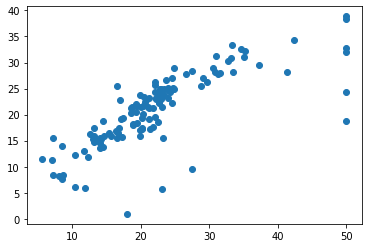

In [59]:
plt.scatter(y_test, predictions)

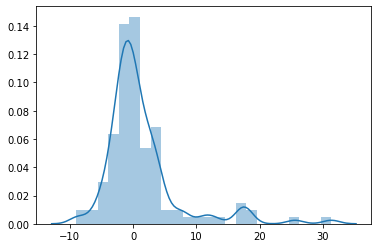

In [60]:
sns.distplot((y_test - predictions))

Evaluate using **Root Mean Squared Error (RMSE)**.

In [61]:
from sklearn import metrics 
np.sqrt(metrics.mean_squared_error(y_test, predictions))

6.142996482475555

## Delete Endpoint 

In [62]:
linear_regressor.delete_endpoint()